# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from feature_engine.creation import CyclicalFeatures

In [34]:
# load weekly sales dataset

filename = "../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

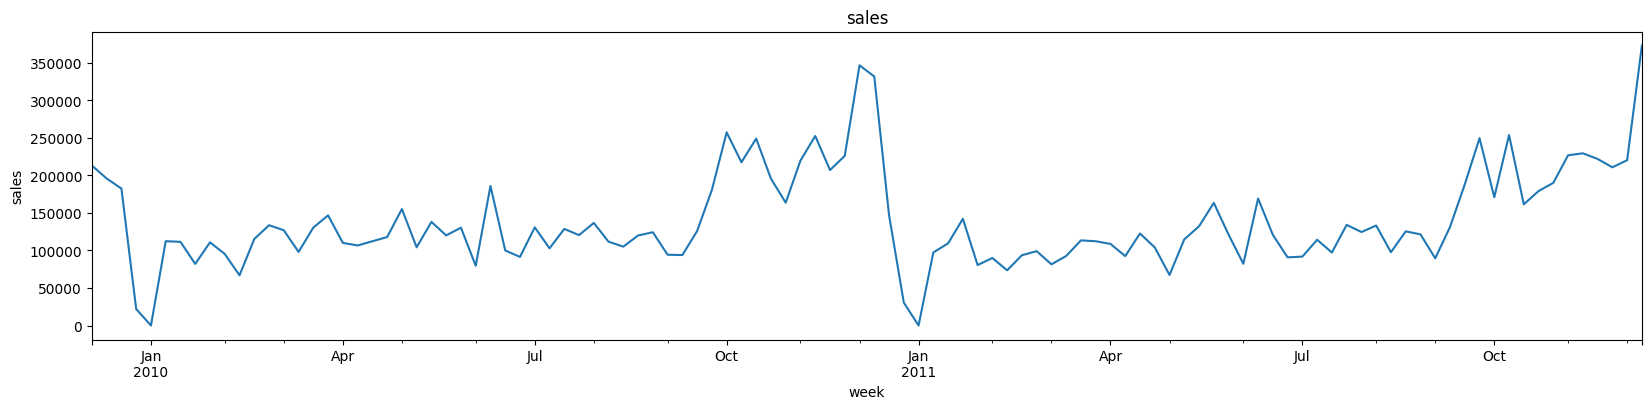

In [35]:
# Plot the time series
df["sales"].plot(figsize=(20, 4))

# Add title
plt.title("sales")

# the y axis label
plt.ylabel("sales")

plt.show()

Some values are 0 for sales, it is that right?

Clearly we see a seasonality in December, probably related to Christmas.

## Missing data

Check if there are missing values in the time series.

In [36]:
df.isna().sum()

sales    0
dtype: int64

We don't have missing values for this series.

## Missing timestamps

Check if there are missing timestamps in the index.

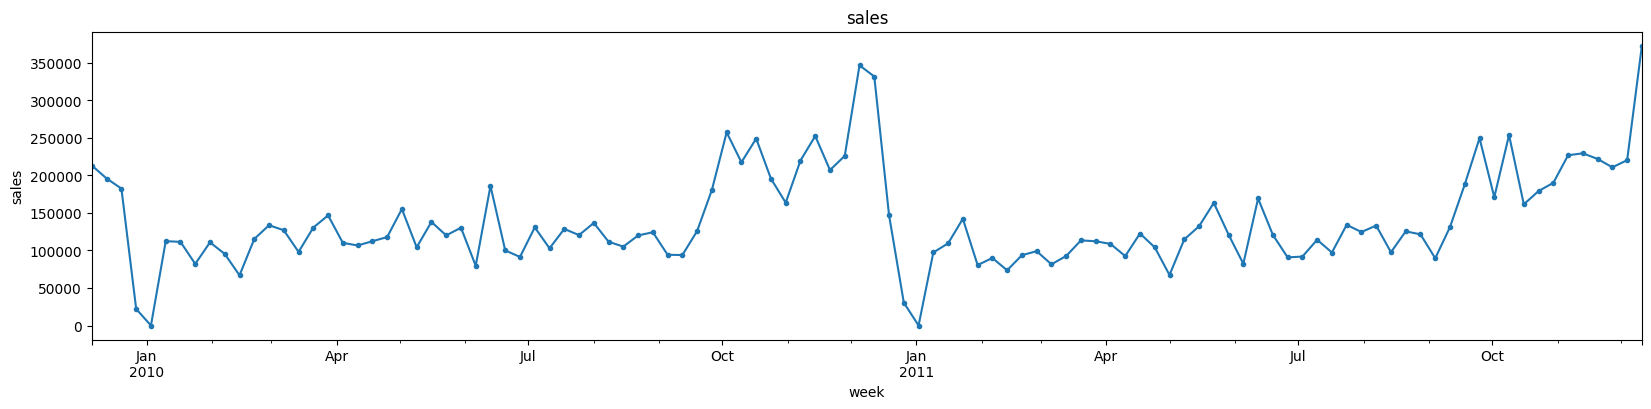

In [37]:
# Introduce the missing timestamps.
# Note that we capture this in a different dataframe.
data_ = df.asfreq("7D")

# Apply the forward fill method.
data_imputed = data_.fillna(method="ffill")

# Plot the imputed time series.

# plot the time series.
ax = data_["sales"].plot(linestyle="-", marker=".", figsize=[20, 4])

# plot the imputed values on top, in red.
data_imputed[data_.isnull()]["sales"].plot(ax=ax, legend=None, marker=".",
                                           color="r")

# Add title.
plt.title("sales")

# the y axis label
plt.ylabel("sales")

plt.show()

We don't have any missing timestamp.

## Seasonality

Does the time series show any obvious seasonal pattern?

/tmp/ipykernel_7291/2263157154.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  time_ = df.index.week


Text(0, 0.5, 'Sales')

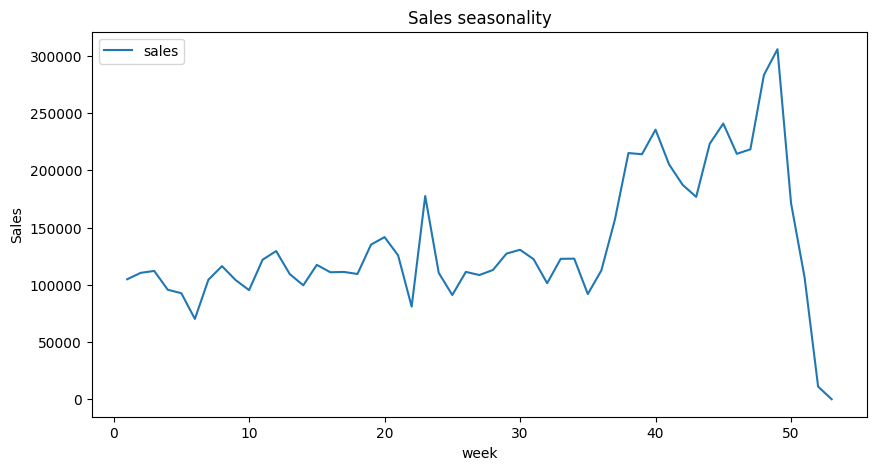

In [38]:
# Capture "time" in a new variable.
time_ = df.index.week
time_ = pd.Series(time_, index=df.index)
# Plot the average sales per week.

df.groupby(time_)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Sales seasonality")
plt.ylabel("Sales")

Text(0, 0.5, 'Sales')

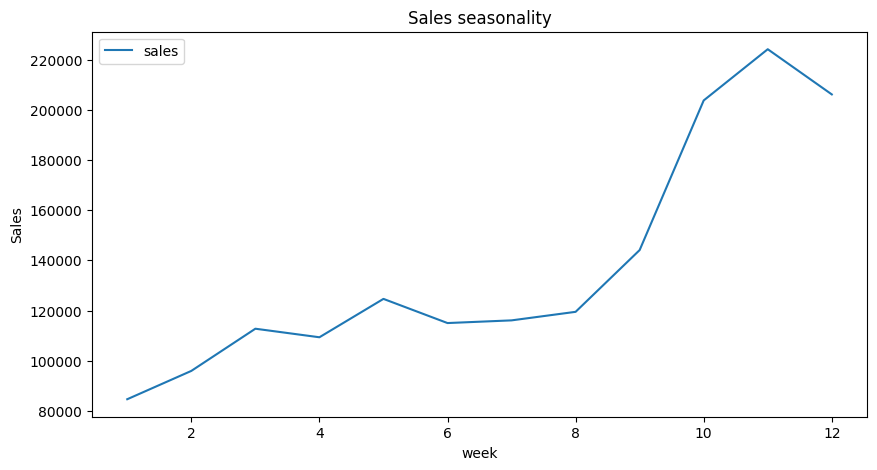

In [39]:
# Capture "time" in a new variable.
time_ = df.index.month
time_ = pd.Series(time_, index=df.index)
# Plot the average sales per month.

df.groupby(time_)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Sales seasonality")
plt.ylabel("Sales")

# Feature engineering

Now, let's begin to tabularize the data.

## Time related features

In [40]:
df["Month"] = df.index.month
df["Week"] = df.index.isocalendar().week
df["Season"] = df.index.month % 12 // 3 + 1


# Show new variables
df.head()

,sales,Month,Week,Season
week,,,,
2009-12-06,213000.35,12,49,1
2009-12-13,195810.04,12,50,1
2009-12-20,182396.74,12,51,1
2009-12-27,22007.77,12,52,1
2010-01-03,0.00,1,53,1


## Lag features

In [41]:
# Here, I show how to move the variables forward by 1 week,
# so that the pollutant concentration from the previous
# week (t-1) is aligned with the current week (t),
# which is the forecasting point.

# raw time series
variables = ["sales"]

# Shift the data forward 1 Hr.
tmp = df[variables].shift(freq="7D")

# Names for the new variables.
tmp.columns = [v + "_lag_1" for v in variables]

# Add the variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(106, 4)
data size after
(106, 5)


,sales,Month,Week,Season,sales_lag_1
week,,,,,
2009-12-06,213000.35,12,49,1,NaN
2009-12-13,195810.04,12,50,1,213000.35
2009-12-20,182396.74,12,51,1,195810.04
2009-12-27,22007.77,12,52,1,182396.74
2010-01-03,0.00,1,53,1,22007.77


In [42]:
df.isnull().sum()

sales          0
Month          0
Week           0
Season         0
sales_lag_1    1
dtype: int64

In [43]:
# Now we repeat the exercise, but this time
# the values are moved forward 2 weeks.

# Move forward 24 hrs.
tmp = df[variables].shift(freq="14D")

# Rename the variables.
tmp.columns = [v + "_lag_2" for v in variables]

# Add the features to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head(3)

data size before
(106, 5)
data size after
(106, 6)


,sales,Month,Week,Season,sales_lag_1,sales_lag_2
week,,,,,,
2009-12-06,213000.35,12,49,1,NaN,NaN
2009-12-13,195810.04,12,50,1,213000.35,NaN
2009-12-20,182396.74,12,51,1,195810.04,213000.35


In [45]:
df.isnull().sum()

sales          0
Month          0
Week           0
Season         0
sales_lag_1    1
sales_lag_2    2
dtype: int64

## Window features

In [46]:
# Use the mean of the 3 previous weeks as input variables.

tmp = (
    df[variables]
    .rolling(window="21D")
    .mean()  # Average the last 3 hr values.
    .shift(freq="7D")  # Move the average 1 week forward
)

# Rename the columns
tmp.columns = [v + "_window" for v in variables]


# view of the result
tmp.head(10)

,sales_window
week,
2009-12-13,213000.350000
2009-12-20,204405.195000
2009-12-27,197069.043333
2010-01-03,133404.850000
2010-01-10,68134.836667
2010-01-17,44775.540000
2010-01-24,74593.106667
2010-01-31,101948.217000
2010-02-07,101438.797333


In [47]:
# Join the new variables to the original data.
print("data size before")
print(df.shape)

df = df.merge(tmp, left_index=True, right_index=True, how="left")

print("data size after")
print(df.shape)

df.head()

data size before
(106, 6)
data size after
(106, 7)


,sales,Month,Week,Season,sales_lag_1,sales_lag_2,sales_window
week,,,,,,,
2009-12-06,213000.35,12,49,1,NaN,NaN,NaN
2009-12-13,195810.04,12,50,1,213000.35,NaN,213000.350000
2009-12-20,182396.74,12,51,1,195810.04,213000.35,204405.195000
2009-12-27,22007.77,12,52,1,182396.74,195810.04,197069.043333
2010-01-03,0.00,1,53,1,22007.77,182396.74,133404.850000


## Periodic Features

In [50]:
# Create features that capture the cyclical representation.

cyclical = CyclicalFeatures(
    variables=["Month", "Week"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

In [51]:
cyclical_vars = [var for var in df.columns if "sin" in var or "cos" in var]

df[cyclical_vars].head()

,Month_sin,Month_cos,Week_sin,Week_cos
week,,,,
2009-12-06,-2.449294e-16,1.000000,-0.456629,0.889657
2009-12-13,-2.449294e-16,1.000000,-0.348202,0.93742
2009-12-20,-2.449294e-16,1.000000,-0.234886,0.972023
2009-12-27,-2.449294e-16,1.000000,-0.118273,0.992981
2010-01-03,5.000000e-01,0.866025,-0.0,1.0


## Drop missing data

In [52]:
# Determine fraction of missing data.

df.isnull().sum() / len(df)

sales           0.000000
Month           0.000000
Week            0.000000
Season          0.000000
sales_lag_1     0.009434
sales_lag_2     0.018868
sales_window    0.009434
Month_sin       0.000000
Month_cos       0.000000
Week_sin        0.000000
Week_cos        0.000000
dtype: float64

## Imputation

There is not a lot of data missing, so I will just remove those observations.

In [53]:
print("data size before")
print(df.shape)

df.dropna(inplace=True)

print("data size after")
print(df.shape)

data size before
(106, 11)
data size after
(104, 11)


## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [55]:
# Find minimum and maximum dates.

df.index.min(), df.index.max()

(Timestamp('2009-12-20 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [56]:
# We will keep data after the last week of September of data to test
# the forecasting models.

X_train = df[df.index <= "2011-09-30"]
X_test = df[df.index > "2011-09-30"]

X_train.shape, X_test.shape

((93, 11), (11, 11))

In [57]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [58]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["sales_lag_1"], squared=False,))

train rmse:  48322.3145945851
test rmse:  65327.34284108387


## Machine Learning

### Random Forests

In [59]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [60]:
# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  25179.684197225244
test rmse:  53053.6415908187


Small uplift with respect to the Naive forecast. The predictions made by the Random Forests return smaller rmse.

Text(0, 0.5, 'Importance')

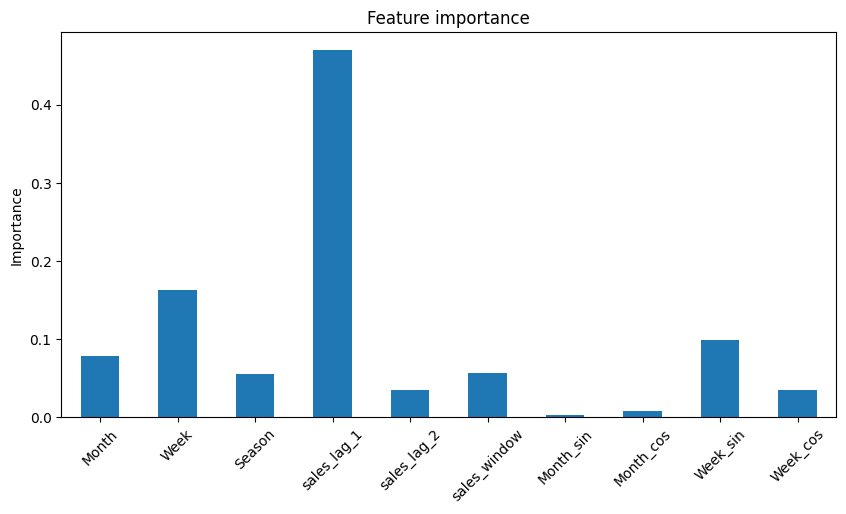

In [64]:
# Let's now plot the feature's importance
# according to the random forests.

# Create series with feature importance.
tmp = pd.Series(rf_model.feature_importances_)

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")

### Linear Regression

In [61]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [62]:
# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  37253.52268711021
test rmse:  65094.9517732021


Small uplift with respect to the Naive forecast. The predictions made by the
Linear Regression return smaller rmse, but a closer mse.

Text(0, 0.5, 'Importance')

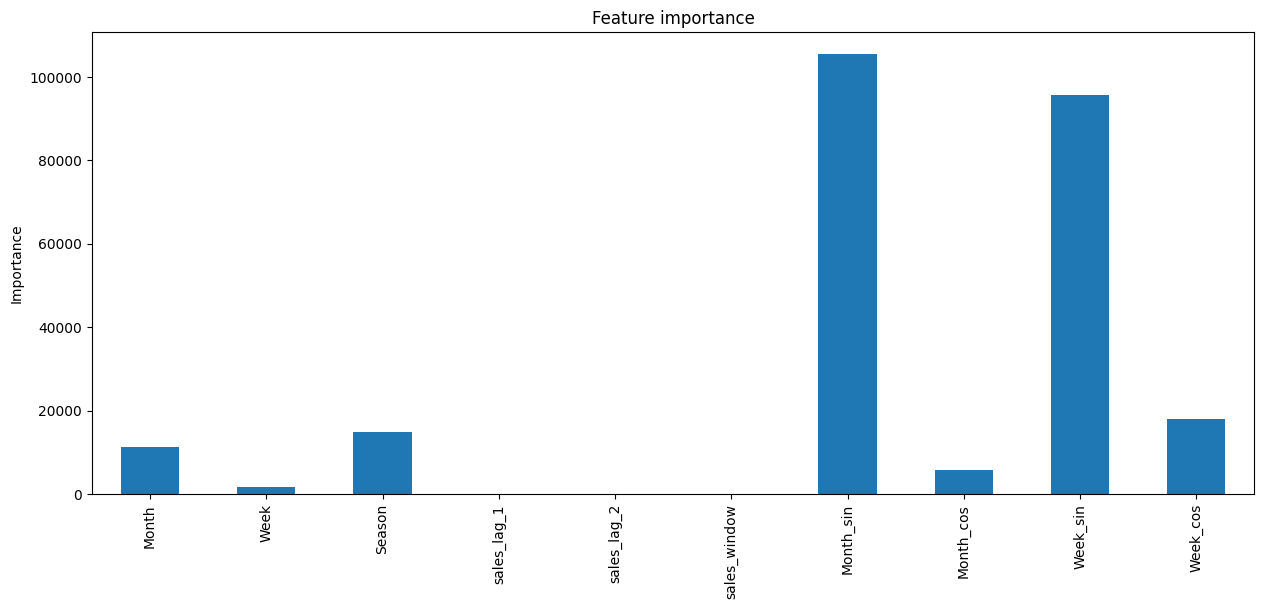

In [63]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")